In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import numpy as np
import pandas as pd
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings("ignore")

In [13]:
dataset_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/"

In [14]:
train_csv = pd.read_csv(dataset_dir+'train.csv')
train_csv.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


In [15]:
train_csv[train_csv.image_id == '9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0


In [16]:
print(train_csv.shape)
print(np.unique(train_csv.image_id).shape)

(67914, 8)
(15000,)


Converting DICOM images into Numpy array and ploting them

In [17]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # not sure why this is done? 
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

def plot_img(img_path, size = (7,7), cmap = 'gray'):
    img = read_xray(img_path)
    plt.figure(figsize=size)
    plt.imshow(img, cmap = cmap)
    plt.show()

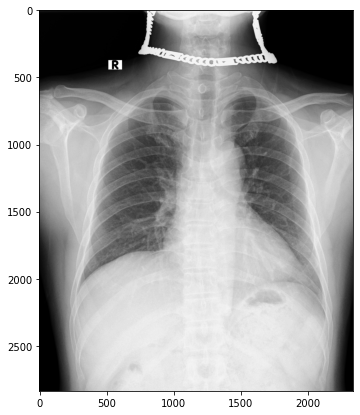

In [18]:
plot_img('../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom')

In [27]:
W = []
H = []
for i in tqdm(os.listdir('../input/vinbigdata-chest-xray-abnormalities-detection/train')):
    data = pydicom.read_file(dataset_dir+'train/'+i)
    w, h = data.Rows, data.Columns
    W.append(w)
    H.append(h)

  0%|          | 0/15000 [00:00<?, ?it/s]

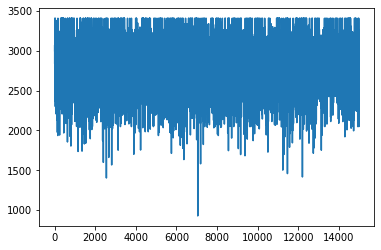

In [28]:
plt.plot(W)

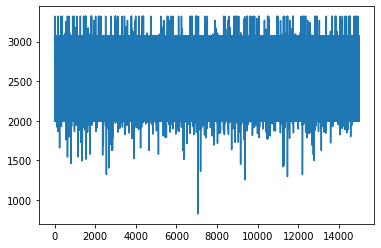

In [29]:
plt.plot(H)

### Looking into CSV file

In [19]:
np.unique(train_csv.class_name)

array(['Aortic enlargement', 'Atelectasis', 'Calcification',
       'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration',
       'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion',
       'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis'], dtype=object)

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64


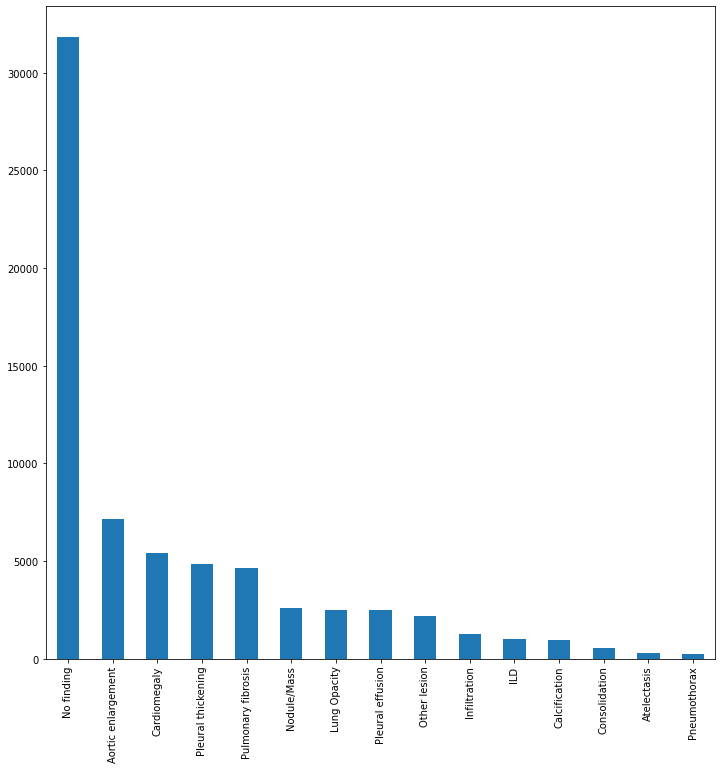

In [20]:
plt.figure(figsize = (12,12))
train_csv['class_name'].value_counts().plot.bar()
print(train_csv['class_name'].value_counts())

In [21]:
(train_csv['class_name'].value_counts())

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [22]:
A = {}
for i in np.unique(train_csv.class_name):
    A[i] = np.unique(train_csv[train_csv['class_name'] == i].image_id).shape[0]
#     print(f"{i}:{np.unique(train_csv[train_csv['class_name'] == i].image_id).shape[0]}")

In [23]:
unique_xrays_count = pd.Series(A)
unique_xrays_count.sort_values(ascending=False)

No finding            10606
Aortic enlargement     3067
Cardiomegaly           2300
Pleural thickening     1981
Pulmonary fibrosis     1617
Lung Opacity           1322
Other lesion           1134
Pleural effusion       1032
Nodule/Mass             826
Infiltration            613
Calcification           452
ILD                     386
Consolidation           353
Atelectasis             186
Pneumothorax             96
dtype: int64

In [24]:
count_df= pd.DataFrame(dict(s1 = (train_csv['class_name'].value_counts()), s2 = unique_xrays_count)).reset_index()
count_df

,index,s1,s2
0,Aortic enlargement,7162,3067
1,Atelectasis,279,186
2,Calcification,960,452
3,Cardiomegaly,5427,2300
4,Consolidation,556,353
5,ILD,1000,386
6,Infiltration,1247,613
7,Lung Opacity,2483,1322
8,No finding,31818,10606
9,Nodule/Mass,2580,826


<AxesSubplot:>

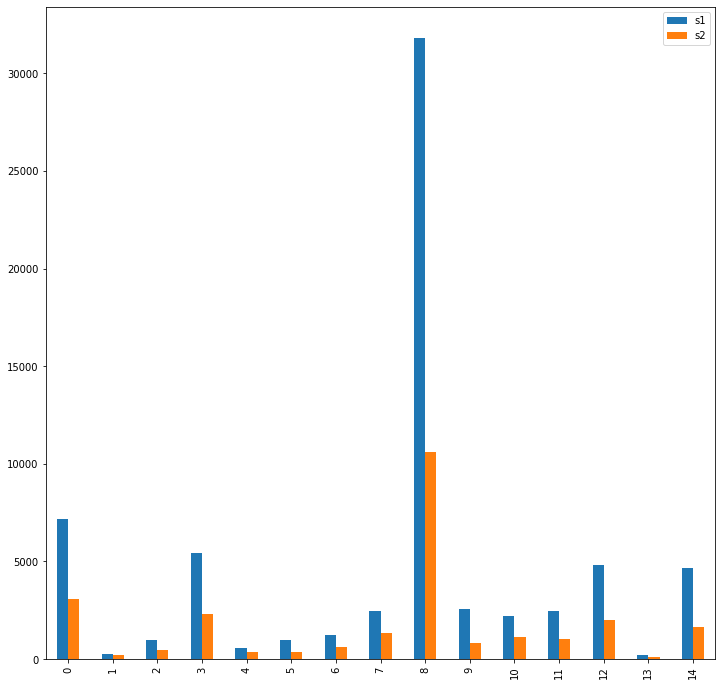

In [25]:
count_df.plot.bar(figsize = (12,12))

In [27]:
train_csv[train_csv.image_id == '063319de25ce7edb9b1c6b8881290140']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
2116,063319de25ce7edb9b1c6b8881290140,No finding,14,R8,NaN,NaN,NaN,NaN
35616,063319de25ce7edb9b1c6b8881290140,No finding,14,R9,NaN,NaN,NaN,NaN
